# EDA и подготовка данных

Импортируем библиотеки

In [122]:
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random

## Загрузка и обзор данных

Дл этого распакуем архив с загруженными данными

In [123]:
DATA_DIR = "../data"

In [124]:
ZIP_PATH = os.path.join(DATA_DIR, "data.zip")

with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(DATA_DIR)

In [125]:
SOURCE_PATH = os.path.join(DATA_DIR, "training.1600000.processed.noemoticon.csv")

data = pd.read_csv(SOURCE_PATH, encoding='latin1', header=None, names=['target', 'ids', 'date', 'flag', 'user', 'text'])

In [126]:
# Загрузим также данные твитов на русском, они понадобятся для моделирования
SOURCE_PATH_RU = os.path.join(DATA_DIR, "rusentitweet_full.csv")

data_ru = pd.read_csv(SOURCE_PATH_RU, usecols=["text", "label"])

In [127]:
random.seed(42)

In [128]:
data.sample(10)

,target,ids,date,flag,user,text
713131,0,2258739868,Sat Jun 20 16:25:10 PDT 2009,NO_QUERY,fictillius,@Shaun_R I'm here with @woosang &amp; @gunzel...
367260,0,2049151382,Fri Jun 05 16:23:04 PDT 2009,NO_QUERY,kaicowboys39,We are going to neuter Marley. He is too agggr...
1059711,4,1963286387,Fri May 29 12:29:42 PDT 2009,NO_QUERY,lyciabycia,@Punjabii hahaha.!! yu are just showing out no...
1025682,4,1883559588,Fri May 22 08:44:42 PDT 2009,NO_QUERY,iowapsychgirl,unpacking and cleaning...open to distractions ...
705823,0,2256491972,Sat Jun 20 12:51:22 PDT 2009,NO_QUERY,darrell,@JeffBishop Yeah. Just a tad disappointing but...
327095,0,2008992218,Tue Jun 02 14:58:52 PDT 2009,NO_QUERY,Libby_Liz,@dawnprawn You know! I think they went to see ...
305104,0,1999910771,Mon Jun 01 21:02:53 PDT 2009,NO_QUERY,Parabolaa,Sprained my wrist at work makes it hard to ty...
428655,0,2063972978,Sun Jun 07 04:46:58 PDT 2009,NO_QUERY,annaaralar,She hates me! http://pikchur.com/az5
317955,0,2002718516,Tue Jun 02 04:59:17 PDT 2009,NO_QUERY,jesszlatos,@amandamandalove its not growing i want it to ...
1528517,4,2177389026,Mon Jun 15 06:01:13 PDT 2009,NO_QUERY,louloufrance,"@spacedlawyer No, just tired today from my lon..."


In [129]:
data.describe()

,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [130]:
# Проверим типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [131]:
data['flag'].value_counts()

flag
NO_QUERY    1600000
Name: count, dtype: int64

Заметим, что столбец flag содержит одинаковое значение для всех строк таблицы. Его можно удалить.

In [132]:
data.drop('flag', axis=1, inplace=True)

In [133]:
# Баланс классов
data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

Типы данных можно оптимизировать.

В данных поровну представлены негативные и позитивные твиты. Нейтральных нет.

In [134]:
data["target"] = (data['target'] == 4).astype(int)
data["ids"] = data["ids"].astype(str)
data["user"] = data["user"].astype(str)
data["date"] = pd.to_datetime(data["date"], errors='coerce')

/var/folders/jg/38zlc6616vl3gdy84xc0lx4w0000gn/T/ipykernel_79489/4193969960.py:4: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data["date"] = pd.to_datetime(data["date"], errors='coerce')


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1600000 non-null  int64         
 1   ids     1600000 non-null  object        
 2   date    1600000 non-null  datetime64[ns]
 3   user    1600000 non-null  object        
 4   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 61.0+ MB


In [136]:
# Проверим пропуски
data.isnull().sum()

target    0
ids       0
date      0
user      0
text      0
dtype: int64

Пропусков в данных нет

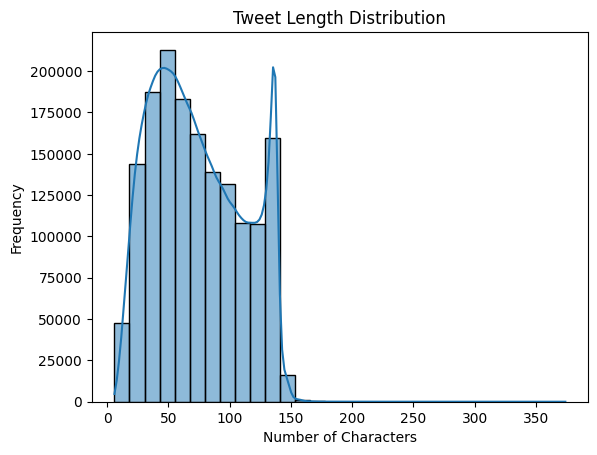

In [137]:
# Построим распределение длины твитов
text_length = data["text"].apply(len)
sns.histplot(text_length, bins=30, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

Мы видим, что в данных содержатся тексты длиннее 160 символов, что являлось ограничением платформы в рассматриваемый период.

In [138]:
# Выведем твит длинее 160 символов
data[data["text"].apply(len) > 160]['text'].to_list()[0]

'Took niece &amp; nephew to Blockbuster- rented &quot;Marley&amp;me&quot;, &amp; &quot;Slumdog Millionaire&quot; Niece kiki799 reinjured ankle @ last night b-ball game '

Данные содержат артефакты и ненужные символы. Их необходимо очистить.

In [139]:
# Очистим текст
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"@\w+", "", text)  # уберем упоминания других пользователей
    text = re.sub(r"https?://\S+", "", text)  # уберем ссылки
    text = re.sub(r"&amp;", "", text)  # уберем '&amp;'
    text = re.sub(r"&quot;", "", text)  # уберем '&quot;'
    text = re.sub(r"[^a-zA-Zа-яА-Я0-9 ]", "", text)  # уберем ненужные символы
    text = re.sub(r"\s+", " ", text).strip()  # уберем повторяющиеся пробелы
    return text.strip()

data.loc[:, 'text'] = data["text"].apply(preprocess_text)

In [140]:
# Удалим строки с пустым текстом
data = data[data['text'] != '']

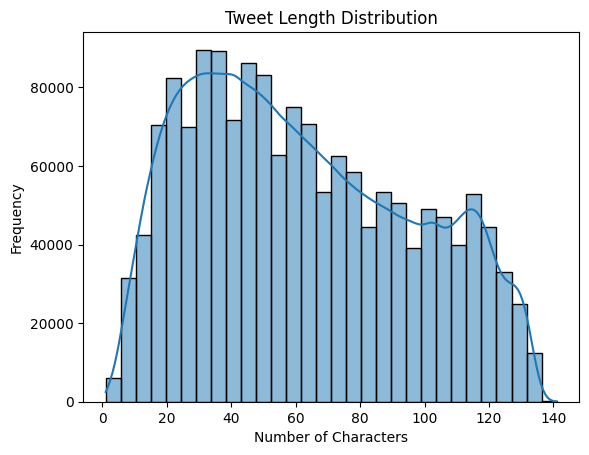

In [141]:
# Заново построим распределение длины твитов
text_length = data["text"].apply(len)
sns.histplot(text_length, bins=30, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

In [142]:
text_length.describe().round()

count    1596421.0
mean          62.0
std           34.0
min            1.0
25%           34.0
50%           57.0
75%           89.0
max          141.0
Name: text, dtype: float64

Медианная длина твита составляет 57 символов.

In [143]:
# Количество уникальных пользовалей 
print("Unique Users:", data["user"].nunique())

Unique Users: 658709


In [144]:
# Самые часто встречающиеся авторы
print(data["user"].value_counts().head(10))

user
lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        273
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
Name: count, dtype: int64


In [145]:
# Проверим дубликаты
data.duplicated().sum()

np.int64(0)

In [146]:
# Найдем дублирующиеся твиты
data.duplicated(subset=["text"]).sum()

np.int64(76631)

In [147]:
# Распределение целевой переменных у дубликатов
data[data.duplicated(subset=["text"])]['target'].value_counts()

target
1    45092
0    31539
Name: count, dtype: int64

В данных содержатся твиты с одинаковым текстом. Удалим их. Также заметим, что большая часть дубликатов были позитивными.

In [148]:
data = data.drop_duplicates(subset=["text"])

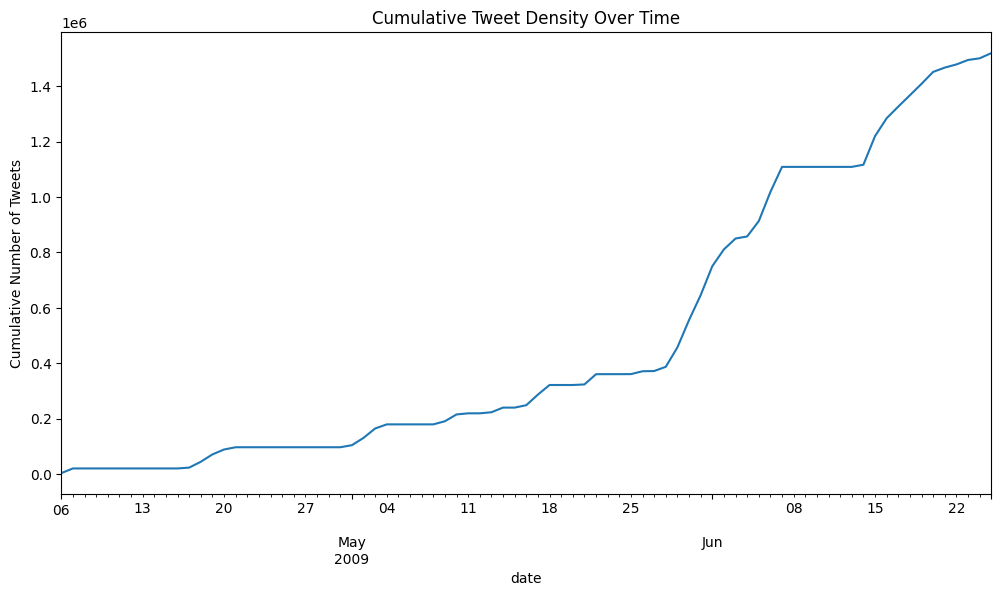

In [149]:
# Общее количество твитов во времени
ts = data.copy()
ts.set_index("date", inplace=True)
ts.resample("D").size().cumsum().plot(figsize=(12,6), title="Cumulative Tweet Density Over Time", ylabel="Cumulative Number of Tweets")
plt.show()

In [150]:
# Наблюдаемый интервал
print(str(ts.index[0]) + ' — ' + str(ts.index[-1]))

2009-04-06 22:19:45 — 2009-06-16 08:40:50


Таким образом твиты собраны за 2 месяца. Значительная часть которых приходится на вторую половину этого периода.

In [151]:
data.sample(5)

,target,ids,date,user,text
1457885,1,2063620168,2009-06-07 03:24:15,elaqiu,yay i just downloaded my favorite music videos...
556719,0,2204350348,2009-06-17 01:59:26,nannigia,feeling sick not go to work today at home alone
636920,0,2234050586,2009-06-18 22:20:32,Malvika_J,blitzkriegm hello there then what a lovely mor...
971925,1,1831350138,2009-05-17 18:42:01,AzTodd74,leaving amos and karas wedding it was beautifu...
235215,0,1979741744,2009-05-31 04:19:10,ClarineV,bbq with step bro jeremycosta and jj theyre go...


In [152]:
# Сохраним очищенные данные
OUTPUT_PATH = os.path.join(DATA_DIR, "cleaned_data.csv")

data.to_csv(OUTPUT_PATH, index=False)

## Обработаем данные твитов на русском языке

In [153]:
data_ru.sample(10)

,text,label
1170,@atiny_KTO_WHO у меня все такие так что 😊😊,neutral
10492,@Ukronos @veria_feeria Сколько подписка на Янд...,neutral
9661,Окей перед тем как пойти спать я посмотрела ст...,skip
4734,@_NaNa_tyan_ @yixing_aiwo Тока скажи есть ли и...,neutral
2283,"""Балаковская АЭС"" озеленит новый ландшафтный п...",neutral
4694,"В среду забрали Окс с дачи, на этом праздники ...",positive
756,@stupid_nerd_ Если его проорет викинг думаю не...,neutral
9999,@yuussssssss теперь это также будет ежедневным...,skip
11328,"То, что сегодня произошло буквально выходит за...",negative
12003,@ramp_toad @slayersky Скоро начнёт уникальные ...,negative


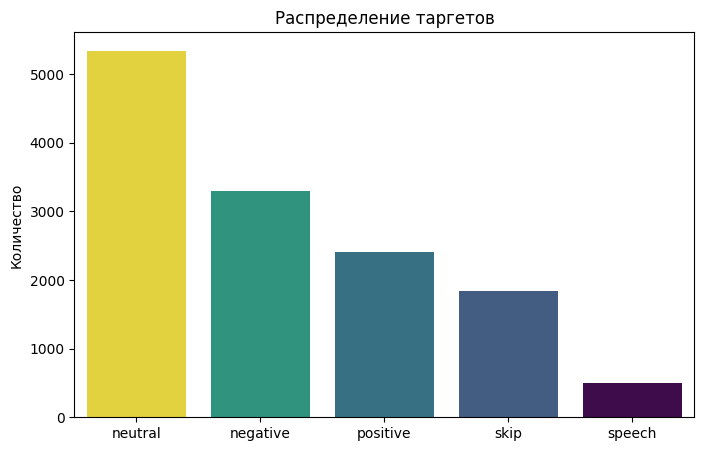

In [154]:
value_counts = data_ru["label"].value_counts().reset_index()
value_counts.columns = ["label", "count"]

plt.figure(figsize=(8, 5))
sns.barplot(data=value_counts, x="label", y="count", hue="count", palette="viridis", legend=False)
plt.xlabel("")
plt.ylabel("Количество")
plt.title("Распределение таргетов")
plt.show()

In [155]:
# Очистим текст
data_ru.loc[:, 'text'] = data_ru["text"].apply(preprocess_text)

Так как в наборе данных твитов на английском есть твиты только двух классов, то для баланса придется убрать все остальные

In [156]:
data_ru = data_ru[data_ru["label"].isin(["negative", "positive"])].copy()
data_ru.loc[:, "label"] = data_ru["label"].replace({"negative": 0, "positive": 1})

/var/folders/jg/38zlc6616vl3gdy84xc0lx4w0000gn/T/ipykernel_79489/3785068141.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_ru.loc[:, "label"] = data_ru["label"].replace({"negative": 0, "positive": 1})


In [157]:
data_ru.rename(columns={"label": "target"}, inplace=True)

In [158]:
data_ru["target"] = data_ru["target"].astype(int)

In [159]:
data_ru.sample(10)

,text,target
4103,мне так противно быть с теми кто может тебя за...,0
10908,раз в год выползая к людям я вспоминаю почему ...,0
8319,я тупая игнорируй,0
8550,какойто маньяк постоянно пишет мне сообщения и...,0
3260,длина вс ещ пугающая цвет вс ещ прекрасный,1
11524,что ты тут забыла тебе здесь не рады уйди забл...,0
10466,ты просто медленно заходишь и игра уже начинается,0
7259,комуто прт но явно не мне пх,0
12079,полиция вышла на протесты нас не уважают через,0
3707,мой крааааш,1


In [160]:
# Сохраним очищенные данные
OUTPUT_PATH = os.path.join(DATA_DIR, "cleaned_data_ru.csv")

data_ru.to_csv(OUTPUT_PATH, index=False)

# Резюме

Мы загрузили данные и провели их предварительный анализ. Для этого были выполнены следующие шаги:

1. Загрузили и структурировали набор данных Sentiment140.
2. Преобразовали соответствующие столбцы в правильные типы данных.
3. Удалили дубликаты твитов, чтобы обеспечить уникальные текстовые записи.
4. Проанализировали распределение целевых настроений.
5. Очистили текст твитов, удалив артефакты, специальные символы и лишние пробелы.
6. Исследовали распределение длины твитов.
7. Выявили активных пользователей.
9. Визуализировали количество твитов во времени с помощью графика кумулятивной плотности.